# Modelagem Estatística

### Banco de 2021

Para a modelagem estatística, irei utilizar uma árvore de decisão pois acredito ser a melhor opção para visualizar quais variáveis são mais e menos importantes na hora de determinar o óbito.

### Transformação das variáveis de idade e tempo de alta e óbito em categóricas

No caso deste problema, há apenas 2 variáveis que não são categóricas, idade e tempo de alta ou óbito. Isso faz com que a árvore de decisão seja enviesada pois estas duas variáveis possibilitam infinitas quebras na árvore, a tornando muito importantes quando analisamos o feature importances e o SHAP. Desse modo, vou transformá-las em categóricas utilizando o pd.cut e ver como ficará o modelo.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

In [2]:
df = pd.read_csv('SRAG_2020_2021.csv', parse_dates=['DT_NOTIFIC'])

df = df[df['tempo_alta_obito_final'] >= 0]

In [3]:
df['idade1'] = pd.qcut(df['idade'], q=5)

In [4]:
df['tempo_alta_obito_final1'] = pd.qcut(df['tempo_alta_obito_final'], q=5)

In [5]:
df['idade1'].value_counts().sort_index()

(-0.001, 39.0]    502254
(39.0, 52.0]      447026
(52.0, 63.0]      478908
(63.0, 75.0]      497105
(75.0, 121.0]     444562
Name: idade1, dtype: int64

In [6]:
df['tempo_alta_obito_final1'].value_counts().sort_index()

(-0.001, 14.0]    506975
(14.0, 36.0]      449796
(36.0, 85.0]      466670
(85.0, 162.0]     477281
(162.0, 703.0]    469133
Name: tempo_alta_obito_final1, dtype: int64

In [7]:
df.to_csv('SRAG_2020_2021_idade_tempo_cat.csv', index=False)

## Seleção das variáveis numéricas e categóricas

Também irei retirar algumas variáveis da análise, como Raça e Estado.

In [7]:
delete_vars = ['raca', 'SG_UF_NOT', 'EVOLUCAO', 'DT_NOTIFIC', 'idade', 'tempo_alta_obito_final']
num_vars = []
dummy_vars = ['gravidez', 'mae_amamenta', 'mae_vacinada_gripe', 'positivo_vsr', 'positivo_para1', 'positivo_para2', 
              'positivo_para3', 'positivo_para4', 'positivo_adeno', 'positivo_sars2', 'positivo_influenza', 'positivo_metap',
             'positivo_boca', 'positivo_rino']

cat_vars = [i for i in df.columns if (i not in delete_vars) and (i not in num_vars) and (i not in dummy_vars)]

model_vars = cat_vars + num_vars + dummy_vars

In [93]:
model_vars

['febre',
 'tosse',
 'dispneia',
 'diarreia',
 'vomito',
 'garganta',
 'desc_resp',
 'saturacao',
 'dor_abd',
 'fadiga',
 'perd_olft',
 'perd_pala',
 'hematologi',
 'cardiopati',
 'asma',
 'diabetes',
 'pneumopati',
 'renal',
 'imunodepre',
 'hepatica',
 'neurologic',
 'obesidade',
 'puerpera',
 'sind_down',
 'CS_SEXO',
 'vacina_gripe',
 'diagnostico',
 'antiviral',
 'suporte_vent',
 'uti',
 'vacina_covid19',
 'idade1',
 'tempo_alta_obito_final1',
 'gravidez',
 'mae_amamenta',
 'mae_vacinada_gripe',
 'positivo_vsr',
 'positivo_para1',
 'positivo_para2',
 'positivo_para3',
 'positivo_para4',
 'positivo_adeno',
 'positivo_sars2',
 'positivo_influenza',
 'positivo_metap',
 'positivo_boca',
 'positivo_rino']

In [8]:
len(model_vars)

47

### Separando em treino e teste (OOT)

O banco de teste será OOT (Out of time). Pode-se ver pela variável DT_NOTIFIC que o banco vai de 29/12/2019 até 09/12/2021 (provável erro). Vou utilizar como treino os casos do início até 31 de junho de 2021. A partir de 01 de julho de 2021 será utilizado como teste (OOT).

Essa divisão traz uma proporção de, aproximadamente 19,7% para teste

In [9]:
df[['DT_NOTIFIC']].describe(datetime_is_numeric=True)

,DT_NOTIFIC
count,2253859
mean,2021-01-07 18:38:20.275573248
min,2019-12-29 00:00:00
25%,2020-08-09 00:00:00
50%,2021-02-04 00:00:00
75%,2021-05-23 00:00:00
max,2021-12-09 00:00:00


In [10]:
data_corte = pd.to_datetime('2021-07-01')

df_train = df[df['DT_NOTIFIC'] <= data_corte].reset_index().copy()
df_test = df[df['DT_NOTIFIC'] >= data_corte].reset_index().copy()

In [11]:
df_train.shape, df_test.shape

((1887549, 54), (371071, 54))

In [12]:
X_train = df_train[model_vars].copy()
y_train = df_train['EVOLUCAO'].copy()

X_test = df_test[model_vars].copy()
y_test = df_test['EVOLUCAO'].copy()

In [13]:
y_train.value_counts(normalize=True)

0    0.689379
1    0.310621
Name: EVOLUCAO, dtype: float64

In [14]:
y_test.value_counts(normalize=True)

0    0.699645
1    0.300355
Name: EVOLUCAO, dtype: float64

A proporção entre 0 e 1 de teste e treino é próxima.

## Modelagem - Árvore de decisão

In [15]:
from sklearn.pipeline import Pipeline
from feature_engine.encoding import OneHotEncoder
from feature_engine.wrappers import SklearnTransformerWrapper

from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score

Para não ter que aplicar em cada loop a transformação das colunas categóricas em dummy, vou fazer o processo apenas 1 vez e aplicar no modelo

In [16]:
onehot = OneHotEncoder()

In [17]:
X_train_transf = onehot.fit_transform(X_train)

X_test_transf = onehot.transform(X_test)

C:\Users\guilh\anaconda3\envs\fia-tcc\lib\site-packages\feature_engine\encoding\one_hot.py:276: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[str(feature) + "_" + str(category)] = np.where(


In [18]:
X_train_transf.shape, X_test_transf.shape

((1887549, 148), (371071, 148))

### Baseline - Modelo sem ajuste de hiperparâmetros

In [19]:
dt = Pipeline(steps=[
    ('dt', DecisionTreeClassifier(random_state=42))
])

In [20]:
dt.fit(X_train_transf, y_train)

Pipeline(steps=[('dt', DecisionTreeClassifier(random_state=42))])

## Avaliação do modelo

### Acurácia

In [21]:
y_pred_train = dt.predict(X_train_transf)
y_pred_test = dt.predict(X_test_transf)
from sklearn.metrics import accuracy_score

print('Acurácia Treino:', accuracy_score(y_train, y_pred_train))
print('Acurácia Teste:', accuracy_score(y_test, y_pred_test))

Acurácia Treino: 0.976693055385582
Acurácia Teste: 0.7255080564096897


### AUROC

In [22]:
from sklearn.metrics import roc_auc_score

y_proba = dt.predict_proba(X_train_transf)[:, 1]

y_proba_test = dt.predict_proba(X_test_transf)[:, 1]


print('AUC Treino:', roc_auc_score(y_train, y_proba))
print('AUC Teste:', roc_auc_score(y_test, y_proba_test))

AUC Treino: 0.9985612411115857
AUC Teste: 0.6825516286439779


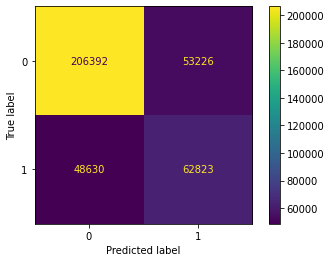

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

### Classification Report

In [24]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_test, target_names=['Alta', 'Obito']))

              precision    recall  f1-score   support

        Alta       0.81      0.79      0.80    259618
       Obito       0.54      0.56      0.55    111453

    accuracy                           0.73    371071
   macro avg       0.68      0.68      0.68    371071
weighted avg       0.73      0.73      0.73    371071



## Feature Importances

Entendendo quais são as características que não podem faltar na triagem de um paciente com suspeita de SRAG

In [25]:
pd.set_option('display.max_rows', 148)

feature_importances_df = pd.DataFrame({
    'features': X_train_transf.columns,
    'importances': dt.steps[-1][1].feature_importances_
}).sort_values(by='importances', ascending=False)

feature_importances_df

,features,importances
125,suporte_vent_Invasivo,0.192038
140,"idade1_(75.0, 121.0]",0.046037
129,uti_Nao,0.031931
141,"idade1_(63.0, 75.0]",0.021510
9,positivo_sars2,0.017376
119,diagnostico_COVID,0.016191
115,vacina_gripe_Ignorado,0.015536
120,antiviral_Nao,0.015106
14,febre_Sim,0.015055
143,"tempo_alta_obito_final1_(84.0, 161.0]",0.014538


In [26]:
pd.reset_option('display.max_rows')

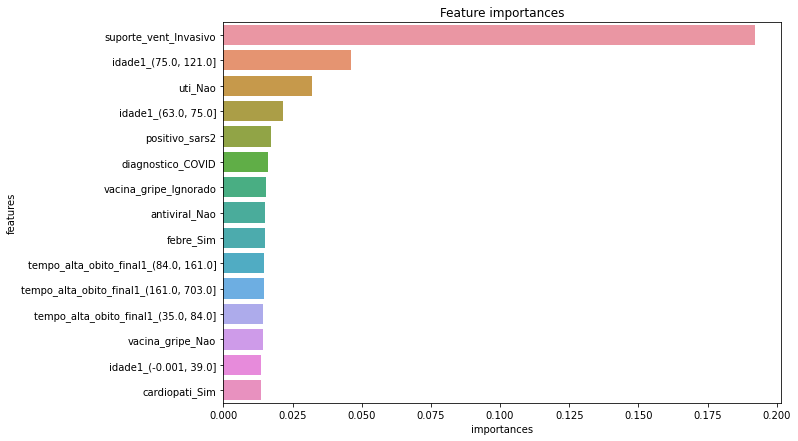

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize = (10,7))
plt.title("Feature importances")
sns.barplot(data = feature_importances_df[:15], x = 'importances', y = 'features')
plt.show()

**OBSERVAÇÃO**

Observa-se uma grande mudança no feature importance em  comparação com o modelo sem alterar as variáveis de idade e tempo de alta. Antes, estas duas variáveis tinham uma importância muito alta pois traziam o viés de serem numéricas. Este modelo é melhor pois remove o viés numérico destas variáveis, assim conseguimos analisar quais faixas desempenham a maior importância no modelo

In [28]:
# import shap

# explainer = shap.Explainer(dt.steps[-1][1])
# shap_values = explainer(X_test_transf)

# shap.plots.beeswarm(shap_values[:, :, 1], max_display = 20)

# O SHAP para o modelo baseline demora demais pois a árvore não tem profundidade limitada

### Modelo com ajuste de hiperparâmetros

Através dos testes anteriores, foi possível observar que a profundidade que trazia maior acurácia era a de 12. Como duas variáveis foram alteradas, vou refazer este teste para ver o que acontecerá.

In [35]:
%%time

profundidade = []
acuracia = []

for depth in range(1, 31):
    dt = Pipeline(steps=[
        ('dt', DecisionTreeClassifier(random_state=42, max_depth=depth))
    ])
    
    dt.fit(X_train_transf, y_train)
    
    y_pred_train = dt.predict(X_train_transf)
    train_accuracy = accuracy_score(y_train, y_pred_train)
    y_pred_test = dt.predict(X_test_transf)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    
    y_proba = dt.predict_proba(X_train_transf)[:, 1]
    y_proba_test = dt.predict_proba(X_test_transf)[:, 1]
    
    profundidade.append(depth)
    acuracia.append(test_accuracy)
    
    print('Profundidade:', depth)
    print('Acurácia Treino:', train_accuracy)
    print('Acurácia Teste:', test_accuracy)
    print('AUC Treino:', roc_auc_score(y_train, y_proba))
    print('AUC Teste:', roc_auc_score(y_test, y_proba_test))
    print('')

Profundidade: 1
Acurácia Treino: 0.7724032594650523
Acurácia Teste: 0.7855639486782853
AUC Treino: 0.6705255087169306
AUC Teste: 0.6815458945720658

Profundidade: 2
Acurácia Treino: 0.7728223214337747
Acurácia Teste: 0.7851624082722714
AUC Treino: 0.7383287084070983
AUC Teste: 0.7450076200002851

Profundidade: 3
Acurácia Treino: 0.7833778089999253
Acurácia Teste: 0.7959339317812494
AUC Treino: 0.7846324371665604
AUC Teste: 0.7963036844435687

Profundidade: 4
Acurácia Treino: 0.7876929287663526
Acurácia Teste: 0.799634032301096
AUC Treino: 0.8089880411095168
AUC Teste: 0.8172288857498168

Profundidade: 5
Acurácia Treino: 0.7881019247712244
Acurácia Teste: 0.7997579977955701
AUC Treino: 0.8237171311282271
AUC Teste: 0.8332609062154563

Profundidade: 6
Acurácia Treino: 0.7916435546838784
Acurácia Teste: 0.801337210399088
AUC Treino: 0.8301234231120229
AUC Teste: 0.8390536670673827

Profundidade: 7
Acurácia Treino: 0.7926369063796489
Acurácia Teste: 0.8021834096439765
AUC Treino: 0.8335106

Observando os resultados é possível notar que há um aumento da acurácia tanto de treino quanto de teste com o aumento da profundidade da árvore, porém, treino e teste passam a divergir a partir dos 15 de profundidade, onde a acurácia de treino aumenta e a de teste diminui, o que indica o início de um _overfit_. É possível observar este mesmo comportamento, também, no AUC. Na casa dos 25 de profundidade já é possível observar a lacuna entre treino e teste, mostrando o _overfit_.

Como há muitas variáveis no banco, uma árvore com profundidade 7 apresenta um bom _trade-off_ nos seguintes quesitos: 
* Possibilidade de ler a árvore
* Não haver overfit
* Bons números de acurácia e AUC

In [36]:
result_profundidade = pd.DataFrame(profundidade, columns=['Profundidade'])
result_profundidade['Acuracia'] = acuracia
result_profundidade

,Profundidade,Acuracia
0,1,0.785564
1,2,0.785162
2,3,0.795934
3,4,0.799634
4,5,0.799758
5,6,0.801337
6,7,0.802183
7,8,0.802404
8,9,0.803410
9,10,0.804808


In [37]:
result_profundidade.to_csv('resultados_loop_profundidade_ajuste_idade_tempo.csv')

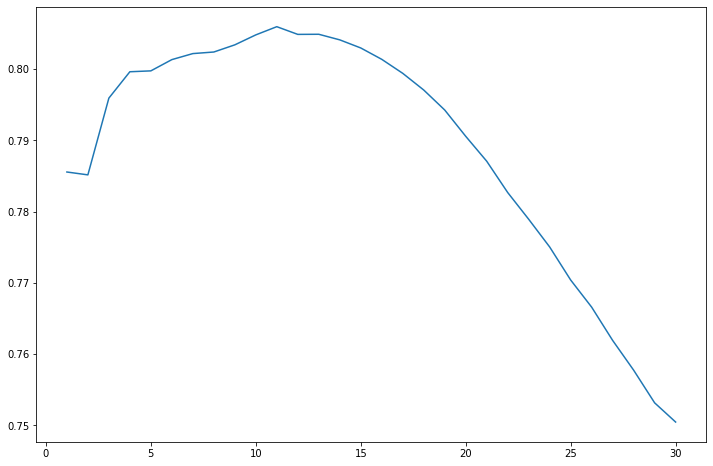

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (12,8))
sns.lineplot(x = profundidade, y = acuracia)
plt.show()

In [39]:
print('Maior acurácia:', max(acuracia), '\nProfundidade:', acuracia.index(max(acuracia))+1)

Maior acurácia: 0.8059589674213291 
Profundidade: 11


Análise do min_samples_leaf

In [70]:
%%time

samp_leaf = [2, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000, 5000, 10000]

acuracia = []

for samples_leaf in samp_leaf:
    dt = Pipeline(steps=[
        # ('one_hot_encoder', OneHotEncoder(variables=cat_vars)),
        ('dt', DecisionTreeClassifier(random_state=42, max_depth=7, min_samples_leaf=samples_leaf))
    ])
    
    dt.fit(X_train_transf, y_train)
    
    y_pred_train = dt.predict(X_train_transf)
    train_accuracy = accuracy_score(y_train, y_pred_train)
    y_pred_test = dt.predict(X_test_transf)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    
    y_proba = dt.predict_proba(X_train_transf)[:, 1]
    y_proba_test = dt.predict_proba(X_test_transf)[:, 1]

    acuracia.append(test_accuracy)
    
    print('min_samples_leaf:', samples_leaf)
    print('Acurácia Treino:', train_accuracy)
    print('Acurácia Teste:', test_accuracy)
    print('AUC Treino:', roc_auc_score(y_train, y_proba))
    print('AUC Teste:', roc_auc_score(y_test, y_proba_test))
    print('')

min_samples_leaf: 2
Acurácia Treino: 0.7926369063796489
Acurácia Teste: 0.8021834096439765
AUC Treino: 0.8335106004888723
AUC Teste: 0.8413459275025671

min_samples_leaf: 100
Acurácia Treino: 0.7926188936022324
Acurácia Teste: 0.8021941892521917
AUC Treino: 0.8334982467660174
AUC Teste: 0.8413387740367343

min_samples_leaf: 200
Acurácia Treino: 0.7925685637829799
Acurácia Teste: 0.8021537657213849
AUC Treino: 0.8334905579081583
AUC Teste: 0.8413444952507455

min_samples_leaf: 300
Acurácia Treino: 0.7925500212179922
Acurácia Teste: 0.8022157484686219
AUC Treino: 0.8334855945646116
AUC Teste: 0.8413423989635377

min_samples_leaf: 400
Acurácia Treino: 0.7925161148134433
Acurácia Teste: 0.8021887994480841
AUC Treino: 0.8334727240288755
AUC Teste: 0.8413313914900981

min_samples_leaf: 500
Acurácia Treino: 0.7925055190620217
Acurácia Teste: 0.8021887994480841
AUC Treino: 0.833439791936263
AUC Teste: 0.8413116958977944

min_samples_leaf: 600
Acurácia Treino: 0.7925055190620217
Acurácia Teste:

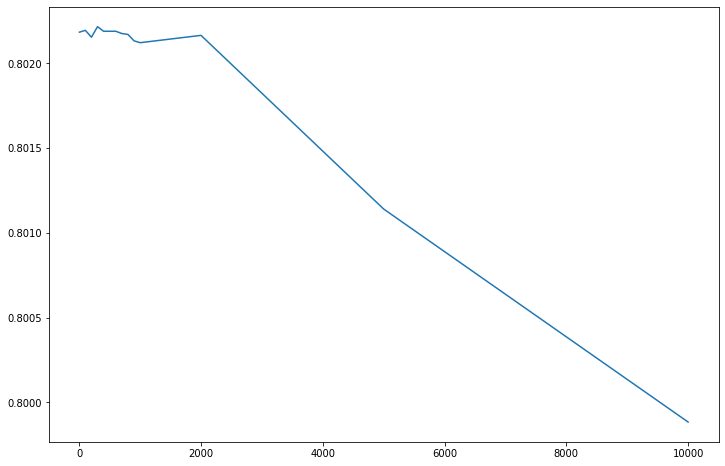

In [71]:
plt.figure(figsize = (12,8))
sns.lineplot(x = samp_leaf, y = acuracia)
plt.show()

Como a acurácia vai descendo com o aumento do min_samples_leaf, vou utilizar 2000 para tentar diminuir o tamanho da árvore que será plotada.

Além disso, vou utilizar class_weight = 'balanced' para tentar balancear os 0 e 1

In [96]:
dt = Pipeline(steps=[
    ('dt', DecisionTreeClassifier(random_state=42, max_depth=7, min_samples_leaf=2000, class_weight = 'balanced'))
])

In [73]:
dt.fit(X_train_transf, y_train)

Pipeline(steps=[('dt',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=7,
                                        min_samples_leaf=2000,
                                        random_state=42))])

## Avaliação do modelo

### Acurácia

In [74]:
y_pred_train = dt.predict(X_train_transf)
y_pred_test = dt.predict(X_test_transf)
from sklearn.metrics import accuracy_score

print('Acurácia Treino:', accuracy_score(y_train, y_pred_train))
print('Acurácia Teste:', accuracy_score(y_test, y_pred_test))

Acurácia Treino: 0.760505819981362
Acurácia Teste: 0.7688744202591957


### AUROC

In [75]:
from sklearn.metrics import roc_auc_score

y_proba = dt.predict_proba(X_train_transf)[:, 1]

y_proba_test = dt.predict_proba(X_test_transf)[:, 1]


print('AUC Treino:', roc_auc_score(y_train, y_proba))
print('AUC Teste:', roc_auc_score(y_test, y_proba_test))

AUC Treino: 0.8333214732323113
AUC Teste: 0.8413517775043302


### Confusion Matrix

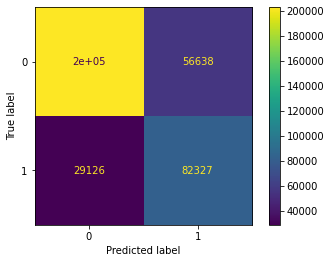

In [76]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

### Classification Report

In [77]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_test, target_names=['Alta', 'Obito']))

              precision    recall  f1-score   support

        Alta       0.87      0.78      0.83    259618
       Obito       0.59      0.74      0.66    111453

    accuracy                           0.77    371071
   macro avg       0.73      0.76      0.74    371071
weighted avg       0.79      0.77      0.78    371071



## Feature Importances

Entendendo quais são as características que não podem faltar na triagem de um paciente com suspeita de SRAG

In [78]:
pd.set_option('display.max_rows', 148)

feature_importances_df = pd.DataFrame({
    'features': X_train_transf.columns,
    'importances': dt.steps[-1][1].feature_importances_
}).sort_values(by='importances', ascending=False)

feature_importances_df

,features,importances
125,suporte_vent_Invasivo,0.488970
140,"idade1_(75.0, 121.0]",0.164030
129,uti_Nao,0.118696
138,"idade1_(-0.001, 39.0]",0.061063
141,"idade1_(63.0, 75.0]",0.044680
119,diagnostico_COVID,0.036274
142,"idade1_(39.0, 53.0]",0.026818
139,"idade1_(53.0, 63.0]",0.020832
126,suporte_vent_Nao,0.012831
147,"tempo_alta_obito_final1_(-0.001, 14.0]",0.005412


In [79]:
pd.reset_option('display.max_rows')

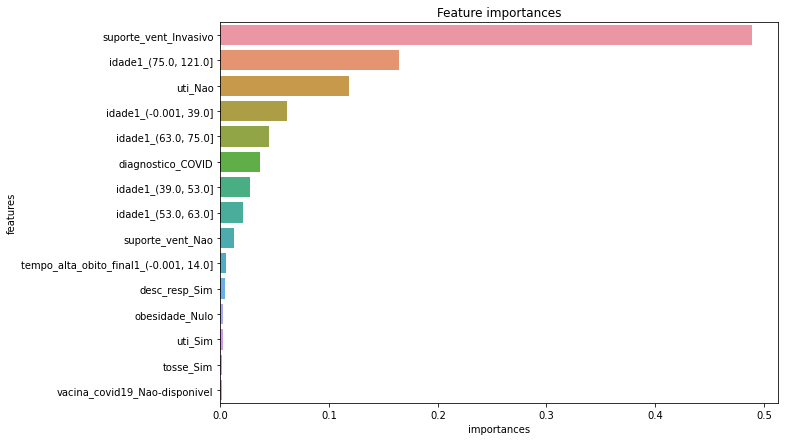

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize = (10,7))
plt.title("Feature importances")
sns.barplot(data = feature_importances_df[:15], x = 'importances', y = 'features')
plt.show()

In [83]:
plt.rcParams['figure.figsize'] = 25, 10

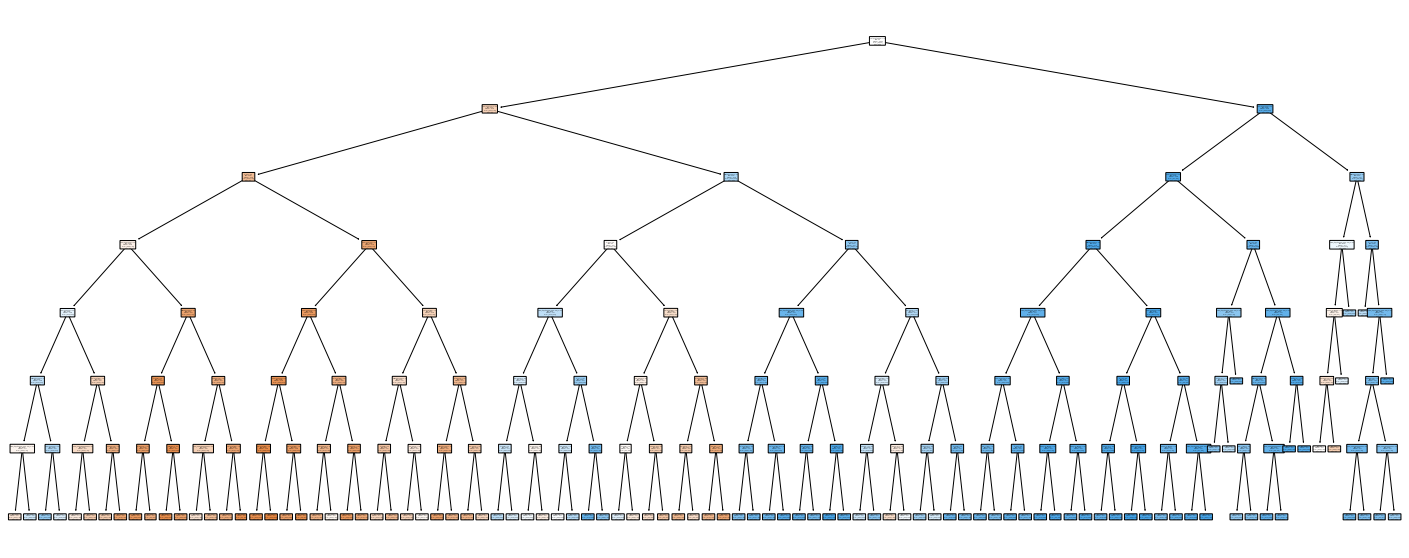

In [84]:
plot_tree(
    dt.steps[-1][1],
    feature_names=X_train_transf.columns,
    class_names=['Alta', 'Obito'],
    rounded=True,
    filled=True,
    proportion=True
);

plt.savefig('tree_7_2000_cat.pdf',format='pdf')

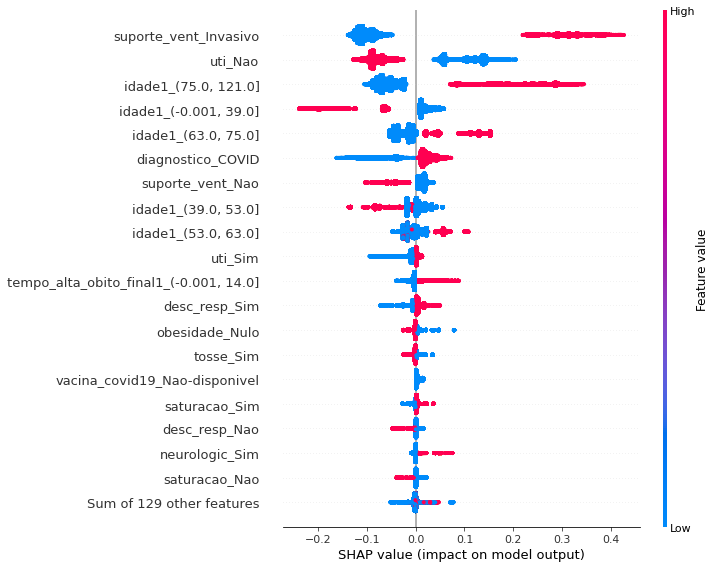

In [82]:
import shap

explainer = shap.Explainer(dt.steps[-1][1])
shap_values = explainer(X_test_transf)

shap.plots.beeswarm(shap_values[:, :, 1], max_display = 20) # 1 é o óbito e 0 a alta

Pode-se observar que o class_weight = 'balanced' faz diferença no modelo, melhorando os verdadeiros positivos, mas, em contra partida, piora os falsos positivos. Como estamos tratando de óbitos, um falso negativo é pior que um falso positivo, portanto podemos seguir desta forma.

## Modelagem - Regressão Logística

No caso da regressão logística, é necessário aplicar o parâmetro drop_last = True ao dummificar as colunas

In [140]:
onehot = OneHotEncoder(drop_last = True)

In [141]:
X_train_transf = onehot.fit_transform(X_train)

X_test_transf = onehot.transform(X_test)

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


In [142]:
X_train_transf.shape, X_test_transf.shape

((1887549, 115), (371071, 115))

### Modelo Baseline

In [143]:
from sklearn.linear_model import LogisticRegression

In [144]:
lr = Pipeline(steps=[
    ('lr', LogisticRegression(random_state=42, max_iter = 1000))
])

In [145]:
lr.fit(X_train_transf, y_train)

Pipeline(steps=[('lr', LogisticRegression(max_iter=1000, random_state=42))])

## Avaliação do modelo

### Acurácia

In [146]:
y_pred_train = lr.predict(X_train_transf)
y_pred_test = lr.predict(X_test_transf)
from sklearn.metrics import accuracy_score

print('Acurácia Treino:', accuracy_score(y_train, y_pred_train))
print('Acurácia Teste:', accuracy_score(y_test, y_pred_test))

Acurácia Treino: 0.7949414823138367
Acurácia Teste: 0.8035658943975681


### AUROC

In [147]:
from sklearn.metrics import roc_auc_score

y_proba = lr.predict_proba(X_train_transf)[:, 1]

y_proba_test = lr.predict_proba(X_test_transf)[:, 1]


print('AUC Treino:', roc_auc_score(y_train, y_proba))
print('AUC Teste:', roc_auc_score(y_test, y_proba_test))

AUC Treino: 0.8418734651953353
AUC Teste: 0.8474017064499967


### Confusion Matrix

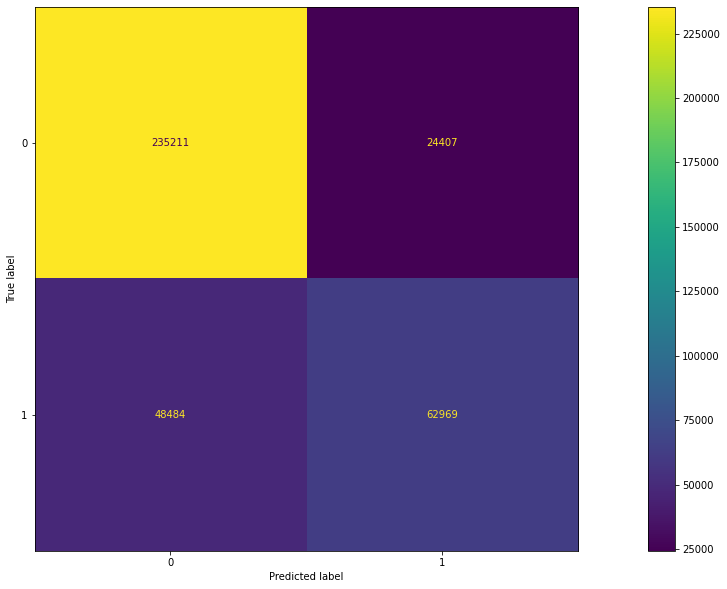

In [148]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

### Classification Report

In [149]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_test, target_names=['Alta', 'Obito']))

              precision    recall  f1-score   support

        Alta       0.83      0.91      0.87    259618
       Obito       0.72      0.56      0.63    111453

    accuracy                           0.80    371071
   macro avg       0.77      0.74      0.75    371071
weighted avg       0.80      0.80      0.80    371071



## Coeficientes

In [152]:
coefs = pd.DataFrame(data = {
    'Colunas': X_train_transf.columns,
    'Coeficientes': lr.steps[-1][1].coef_.ravel()
})

In [159]:
coefs_ordenado = coefs.reindex(coefs.Coeficientes.abs().sort_values(ascending = False).index).reset_index(drop=True)

In [168]:
coefs_ordenado.loc[0, :] = ['Intercepto', lr.steps[-1][1].intercept_]

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [169]:
coefs_ordenado

,Colunas,Coeficientes
0,Intercepto,1.074770
1,suporte_vent_Invasivo,1.379579
2,"idade1_(63.0, 75.0]",1.097228
3,positivo_vsr,-0.948461
4,suporte_vent_Nao,-0.915758
5,diagnostico_Influenza,-0.862830
6,mae_vacinada_gripe,-0.732715
7,diagnostico_Desconhecido,-0.721748
8,positivo_rino,-0.714222
9,imunodepre_Sim,0.701256


Observa-se que a regressão logística considera que suporte ventilatório, idade, diagnósticos e algumas comorbidades como mais importantes para o óbito (coefs positivos), porém, trata-se de um banco com muitas colunas, assim a regressão logística não é muito indicada, melhor permanecer com a árvore.

### Utilizando o class_weight = 'balanced'

In [170]:
lr = Pipeline(steps=[
    ('lr', LogisticRegression(random_state=42, max_iter = 1000, class_weight='balanced'))
])

In [171]:
lr.fit(X_train_transf, y_train)

Pipeline(steps=[('lr',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

## Avaliação do modelo

### Acurácia

In [172]:
y_pred_train = lr.predict(X_train_transf)
y_pred_test = lr.predict(X_test_transf)
from sklearn.metrics import accuracy_score

print('Acurácia Treino:', accuracy_score(y_train, y_pred_train))
print('Acurácia Teste:', accuracy_score(y_test, y_pred_test))

Acurácia Treino: 0.7664971876226789
Acurácia Teste: 0.7685725912291718


### AUROC

In [173]:
from sklearn.metrics import roc_auc_score

y_proba = lr.predict_proba(X_train_transf)[:, 1]

y_proba_test = lr.predict_proba(X_test_transf)[:, 1]


print('AUC Treino:', roc_auc_score(y_train, y_proba))
print('AUC Teste:', roc_auc_score(y_test, y_proba_test))

AUC Treino: 0.841993499727752
AUC Teste: 0.8474905455649809


### Confusion Matrix

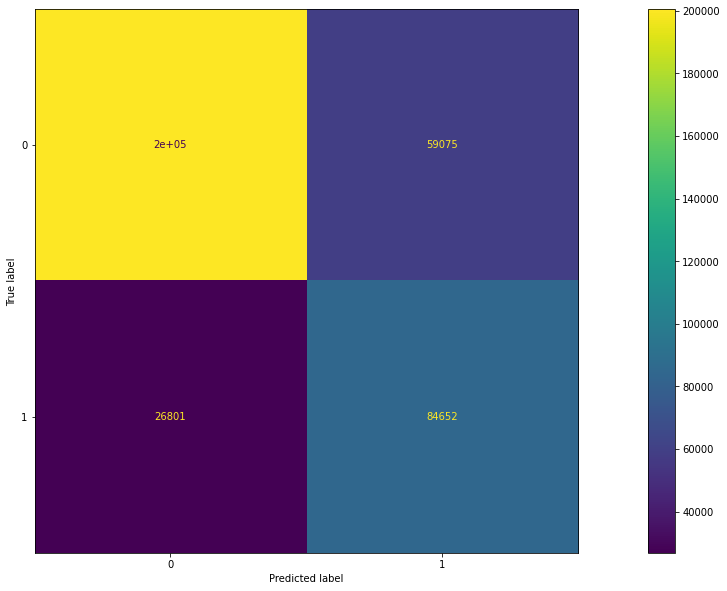

In [174]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

### Classification Report

In [175]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_test, target_names=['Alta', 'Obito']))

              precision    recall  f1-score   support

        Alta       0.88      0.77      0.82    259618
       Obito       0.59      0.76      0.66    111453

    accuracy                           0.77    371071
   macro avg       0.74      0.77      0.74    371071
weighted avg       0.79      0.77      0.78    371071



## Coeficientes

In [176]:
coefs = pd.DataFrame(data = {
    'Colunas': X_train_transf.columns,
    'Coeficientes': lr.steps[-1][1].coef_.ravel()
})

In [177]:
coefs_ordenado = coefs.reindex(coefs.Coeficientes.abs().sort_values(ascending = False).index).reset_index(drop=True)

In [178]:
coefs_ordenado.loc[0, :] = ['Intercepto', lr.steps[-1][1].intercept_]

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [179]:
coefs_ordenado

,Colunas,Coeficientes
0,Intercepto,1.969050
1,suporte_vent_Invasivo,1.396828
2,"idade1_(63.0, 75.0]",1.111321
3,positivo_vsr,-0.982312
4,suporte_vent_Nao,-0.915479
5,diagnostico_Influenza,-0.857749
6,imunodepre_Sim,0.737448
7,positivo_rino,-0.704383
8,sind_down_Sim,0.697561
9,diagnostico_Desconhecido,-0.685238


Aplicar o class_weight = 'balanced' melhora o recall porém diminui a precisão. 

O modelo de regressão logística não teve muita diferença nos resultados quanto a árvore de decisão, porém acredito que a árvore de decisão tem melhor interpretabilidade e é mais fácil de explicar.